Project for the course "Advanced Computer Vision".

Group members:
- Andrea Ceron
- Mattias Trettel
- Ivan Donà

NOTE: When loading the model (see section [Loading the model](#hf-token)), insert your personal Hugging Face user token token. To create one, check their [website](https://huggingface.co/docs/hub/security-tokens).

# VisDiff pipeline re-implementation

The VisDiff pipeline [1] provides an automatic procedure to describe the differences between two sets of images in natural language. Basically, given two sets of images, we want to receive a description in natural language that is more true for the first set than for the second set.

The pipeline has 4 main steps:

1. Image captioning: Use BLIP-2 to caption the the two sets of images, so that we end up with two sets of caption.

2. Proposing difference: Prompt an LLM (GPT-4) to propose the differences in the two sets of captions, i.e. concepts that are more true for the first set than for the second set.

3. Ranking differences: Use CLIP to compare the similarity between the proposed differences and the two sets of images. Rank the proposed differences based on this similarity.

4. Evaluation: Prompt an LLM (GPT-4) to score the similarity between proposed differences and the ground truth. The scores can be: 0 (no match), 0.5 (partial match) or 1 (complete match). Measure Acc@k, which is the highest score of any of the top-k
proposals.


In this notebook we re-implement the VisDiff pipeline using more lightweight models, while also slightly modifying it. In particular, before captioning the image, we do a panoptic segmentation. We do this to obtain more detailed captions, so that the LLM can capture more nuanced differences.

[1] Describing Differences in Image Sets with Natural Language (https://arxiv.org/abs/2312.02974).

## Initial setup



In [ ]:
!pip install -U bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 MB 6.3 MB/s eta 0:00:00


### AT THIS STEP IT IS NEEDED TO RESTART THE RUNTIME FOR THE UPDATE TO TAKE EFFECT

### IF THIS STEP IS SKIPPED THE PIPELINE WON'T WORK

---



Download of the dataset, created by us from from images of the original dataset and pictures online. In this version there are more than one differences for each of the possible 5 pairs, in increasing difficulty

In [ ]:
from google.colab import output

In [ ]:
!gdown 18KM3N4XxCwNJ3jF_e4cJRiHqCs34mzbr
!unzip -o Dataset.zip
output.clear()

## Panoptic segmentation

At this step, differently from the original pipeline, we do a panoptic segmentation before doing the image captioning. This means creating a segmentation map for the image, while also detecting and distinguishing individual instances of objects within those regions.

By doing so, we hope to capture more nuanced differences between the images.


### Loading the segmentation model

Importing the segmentation model from Facebook AI Research's library: `detectron2`. In particular, we use `R101-FPN` (trained on COCO dataset), a ResNet+FPN (Feature Pyramid Network) backbone with standard conv and FC heads for mask and box prediction, respectively. This model can differentiate between things (like people, cars, dogs, etc.) and stuff (like snow/grass/dirt in the background). In this notebook we will refer to this model as the "`detectron2` model".

In [ ]:
import sys, os, distutils.core
!git clone 'https://github.com/facebookresearch/detectron2'
sys.path.insert(0, os.path.abspath('./detectron2'))
dist = distutils.core.run_setup("./detectron2/setup.py")
print(dist.install_requires)
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
output.clear()

In [ ]:
!wget https://dl.fbaipublicfiles.com/detectron2/COCO-PanopticSegmentation/panoptic_fpn_R_101_3x/139514519/model_final_cafdb1.pkl
output.clear()

In [ ]:
import torch, detectron2
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

torch:  2.5 ; cuda:  cu121
detectron2: 0.6


In [ ]:
from PIL import Image
import requests
import gc
import cv2
import matplotlib.pyplot as plt
import sys, os, distutils.core

import pandas as pd
import numpy as np
import json, random
from tqdm import tqdm

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

Here it can be selected under which pair the test will be on, as the number increased the difficulty increases

In [ ]:
test_version = 1 # @param [1, 2, 3, 4, 5] {type:"raw"}
data = pd.read_json(path_or_buf='Dataset/diff.jsonl', lines=True)

data = data.iloc[test_version-1]

Here are loaded the selected images, and displayed the first one to give an idea of the content

In [ ]:
all_set1_images = []
for index, img in enumerate(tqdm(data["set1_images"])):
  all_set1_images.append(cv2.cvtColor(cv2.imread(f'Dataset/{img}'), cv2.COLOR_BGR2RGB))

all_set2_images = []
for index, img in enumerate(tqdm(data["set2_images"])):
  all_set2_images.append(cv2.cvtColor(cv2.imread(f'Dataset/{img}'), cv2.COLOR_BGR2RGB))

100%|██████████| 10/10 [00:00<00:00, 237.99it/s]


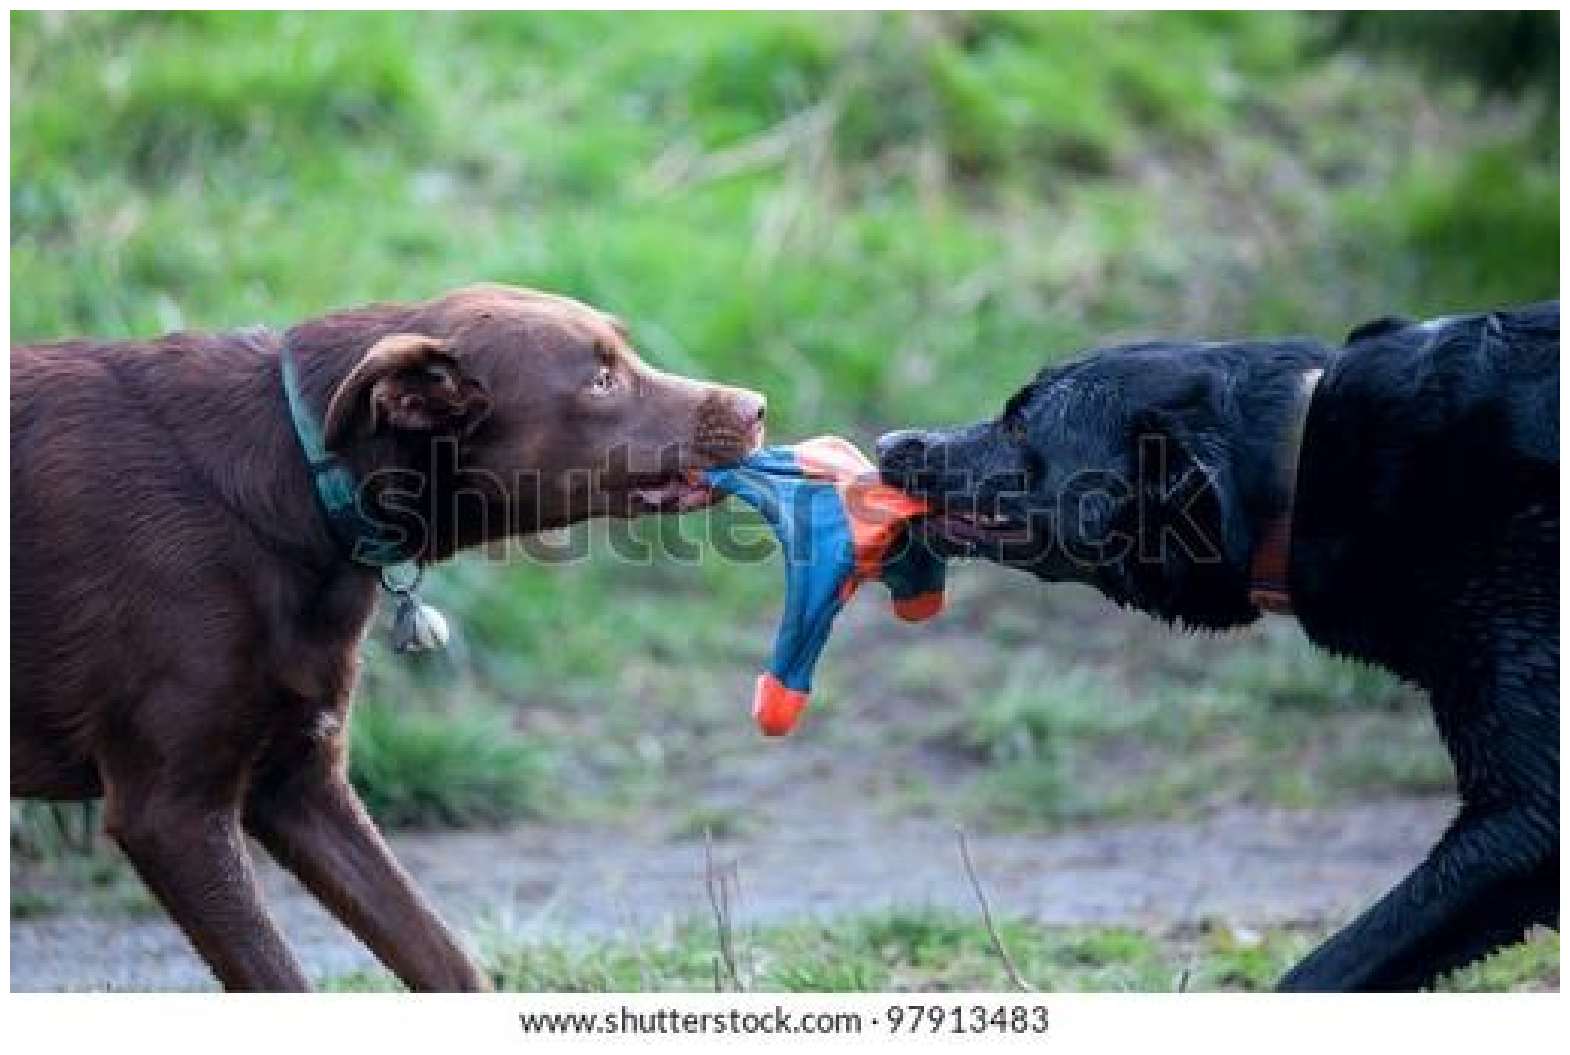

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(all_set1_images[0])
plt.axis('off')
plt.show()

### Image segmentation

Here the separation for each image between things and stuff is done by the `detectron2` model, and an image is shown to give an idea of the result

In [ ]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml")
predictor = DefaultPredictor(cfg)

all_set1_segmentations = []
for index, img in enumerate(tqdm(all_set1_images)):
  panoptic_seg, segments_info = predictor(img)["panoptic_seg"]
  all_set1_segmentations.append((panoptic_seg.to("cpu"), segments_info))

all_set2_segmentations = []
for index, img in enumerate(tqdm(all_set2_images)):
  panoptic_seg, segments_info = predictor(img)["panoptic_seg"]
  all_set2_segmentations.append((panoptic_seg.to("cpu"), segments_info))

  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
100%|██████████| 10/10 [00:02<00:00,  3.99it/s]


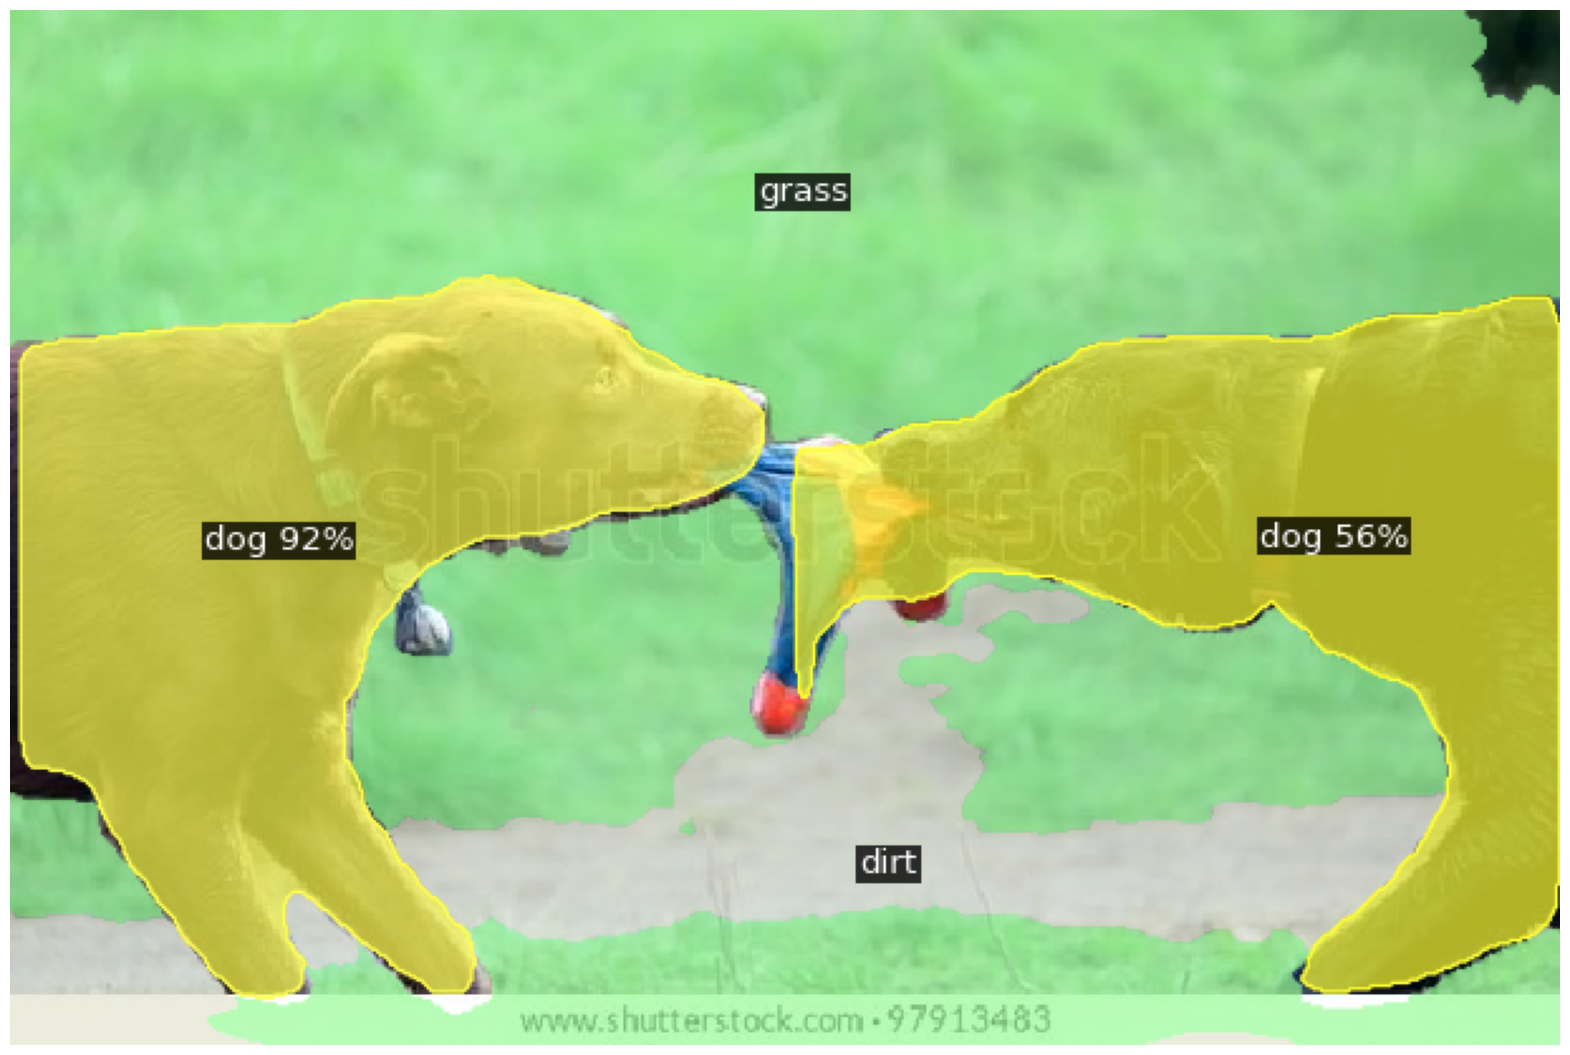

In [ ]:
ID = 0
plt.figure(figsize=(20,20))
v = Visualizer(all_set1_images[ID][:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
plt.imshow(v.draw_panoptic_seg_predictions(all_set1_segmentations[ID][0], all_set1_segmentations[ID][1]).get_image()[:, :, ::-1])
plt.axis('off')
plt.show()

### HERE THE `detectron2` MODEL GETS REMOVED FROM MEMORY, IT WILL TAKE A WHILE TO HAPPEN

If not waiting for this the next cell might crash the runtime for an overflow on VRAM

In [ ]:
del predictor
gc.collect()
torch.cuda.empty_cache()
gc.collect()
torch.cuda.empty_cache()
gc.collect()

0

### Loading the captioning model

After making some space on the GPU, the `blip2` captioning model is loaded into memory

In [ ]:
# pip install accelerate
import requests
from PIL import Image
from transformers import Blip2Processor, Blip2ForConditionalGeneration

processor = Blip2Processor.from_pretrained("Salesforce/blip2-flan-t5-xl")
model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-flan-t5-xl", device_map="auto")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

### Image captioning

Here for all the complete images the captioning is extracted

In [ ]:
all_set1_captions = []
for index, img in enumerate(tqdm(all_set1_images)):
  question = "Question: Describe this image in detail. Answer:"
  inputs = processor(img, question, return_tensors="pt").to("cuda")
  out = model.generate(**inputs)
  all_set1_captions.append([processor.decode(out[0], skip_special_tokens=True)])

all_set2_captions = []
for index, img in enumerate(tqdm(all_set2_images)):
  question = "Question: Describe this image in detail. Answer:"
  inputs = processor(img, question, return_tensors="pt").to("cuda")
  out = model.generate(**inputs)
  all_set2_captions.append([processor.decode(out[0], skip_special_tokens=True)])

  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
100%|██████████| 10/10 [00:59<00:00,  5.99s/it]


In [ ]:
metadata = MetadataCatalog.get(cfg.DATASETS.TRAIN[0])
category_mapping = {i: name for i, name in enumerate(metadata.thing_classes)}

Here the captioning is instead extracted from the `thing` istances for each image. For giving a bit more of context to the `blip2` captioner a configurable padding (standard value of 10) is used. To avoid having to caption every small object, that would increase the time of operations just to create very likely just some hallucinated captions (given the resolution) we remove crops less than 30x30 pixels.

In [ ]:
padding = 10 # @param {type:"integer"}
debug_printing = False # @param {type:"boolean"}
min_crop_width = 30 # @param {type:"integer"}
min_crop_height = 30 # @param {type:"integer"}

for index, img in enumerate(tqdm(all_set1_images)):
    seg_captions = []
    panoptic_seg, segments_info = all_set1_segmentations[index]
    for segment in segments_info:
        if segment["isthing"] and segment["score"] > 0.75:
            y_indices, x_indices = np.where(panoptic_seg == segment["id"])
            x_min, x_max = x_indices.min(), x_indices.max()
            y_min, y_max = y_indices.min(), y_indices.max()

            img_width, img_height = img.shape[:2]

            x_min = max(x_min - padding, 0)
            y_min = max(y_min - padding, 0)
            x_max = min(x_max + padding, img_width)
            y_max = min(y_max + padding, img_height)

            if((x_max-x_min)>min_crop_width and (y_max-y_min)>min_crop_height):
                cropped_img = img[y_min:y_max, x_min:x_max, :]

                obj_type = category_mapping[segment["category_id"]]

                question = f"Question: Describe in detail what this {obj_type} looks like. Answer:"
                inputs = processor(cropped_img, question, return_tensors="pt").to("cuda")
                out = model.generate(**inputs)
                seg_captions.append(processor.decode(out[0], skip_special_tokens=True))
                if(debug_printing):
                    plt.figure()
                    plt.imshow(cropped_img)
                    plt.axis('off')
                    plt.show()
                    print(f"{question} {processor.decode(out[0], skip_special_tokens=True)} Confidence: {segment['score']} - Height: {y_max-y_min} Widht: {x_max-x_min}")
    all_set1_captions[index] = all_set1_captions[index] + seg_captions

for index, img in enumerate(tqdm(all_set2_images)):
    seg_captions = []
    panoptic_seg, segments_info = all_set2_segmentations[index]
    for segment in segments_info:
        if segment["isthing"] and segment["score"] > 0.75:
            y_indices, x_indices = np.where(panoptic_seg == segment["id"])
            x_min, x_max = x_indices.min(), x_indices.max()
            y_min, y_max = y_indices.min(), y_indices.max()

            img_width, img_height = img.shape[:2]

            x_min = max(x_min - padding, 0)
            y_min = max(y_min - padding, 0)
            x_max = min(x_max + padding, img_width)
            y_max = min(y_max + padding, img_height)

            if((x_max-x_min)>min_crop_width and (y_max-y_min)>min_crop_height):
                cropped_img = img[y_min:y_max, x_min:x_max, :]

                obj_type = category_mapping[segment["category_id"]]

                question = f"Question: Describe in detail what this {obj_type} looks like. Answer:"
                inputs = processor(cropped_img, question, return_tensors="pt").to("cuda")
                out = model.generate(**inputs)
                seg_captions.append(processor.decode(out[0], skip_special_tokens=True))
                if(debug_printing):
                    plt.figure()
                    plt.imshow(cropped_img)
                    plt.axis('off')
                    plt.show()
                    print(f"{question} {processor.decode(out[0], skip_special_tokens=True)} Confidence: {segment['score']} - Height: {y_max-y_min} Widht: {x_max-x_min}")
    all_set2_captions[index] = all_set2_captions[index] + seg_captions

100%|██████████| 10/10 [01:15<00:00,  7.50s/it]


Then finally the captioning of the background is done, filtering for each image the entries without the `thing` attribute

In [ ]:
debug_printing = False # @param {type:"boolean"}

for index, img in enumerate(tqdm(all_set1_images)):
  seg_matrix = all_set1_segmentations[index][0]
  seg_info = all_set1_segmentations[index][1]

  thing_ids = {segment['id'] for segment in seg_info if segment['isthing']}

  for thing_id in thing_ids:
      seg_matrix[seg_matrix == thing_id] = 0  # Set "thing" areas to background (0)

  raw_image_tensor = torch.Tensor(img)

  if len(raw_image_tensor.shape) == 2:  # Grayscale image
      raw_image_tensor = raw_image_tensor.unsqueeze(-1).repeat(1, 1, 3)

  background_image_tensor = torch.where(
      seg_matrix.unsqueeze(-1) == 0,
      torch.zeros_like(raw_image_tensor),
      raw_image_tensor
  )

  background_image = Image.fromarray(background_image_tensor.cpu().numpy().astype(np.uint8))

  question = f"Question: Describe in detail how the environment looks like. Answer:"
  inputs = processor(background_image, question, return_tensors="pt").to("cuda")
  out = model.generate(**inputs)
  text = processor.decode(out[0], skip_special_tokens=True)
  if(not text == "Describe in detail how the environment looks like." and not text == "Describe the environment in detail"):
    all_set1_captions[index].append(text)
  elif(debug_printing):
    print("Caption non added")

  if(debug_printing):
    plt.figure()
    plt.imshow(background_image)
    plt.axis("off")
    plt.show()
    print(f"{question} {processor.decode(out[0], skip_special_tokens=True)}")

for index, img in enumerate(tqdm(all_set2_images)):
  seg_matrix = all_set2_segmentations[index][0]
  seg_info = all_set2_segmentations[index][1]

  thing_ids = {segment['id'] for segment in seg_info if segment['isthing']}

  for thing_id in thing_ids:
      seg_matrix[seg_matrix == thing_id] = 0  # Set "thing" areas to background (0)

  raw_image_tensor = torch.Tensor(img)

  if len(raw_image_tensor.shape) == 2:  # Grayscale image
      raw_image_tensor = raw_image_tensor.unsqueeze(-1).repeat(1, 1, 3)

  background_image_tensor = torch.where(
      seg_matrix.unsqueeze(-1) == 0,
      torch.zeros_like(raw_image_tensor),
      raw_image_tensor
  )

  background_image = Image.fromarray(background_image_tensor.cpu().numpy().astype(np.uint8))

  question = f"Question: Describe in detail how the environment looks like. Answer:"
  inputs = processor(background_image, question, return_tensors="pt").to("cuda")
  out = model.generate(**inputs)
  text = processor.decode(out[0], skip_special_tokens=True)
  if(not text == "Describe in detail how the environment looks like." and not text == "Describe the environment in detail"):
    all_set2_captions[index].append(text)
  elif(debug_printing):
    print("Caption non added")

  if(debug_printing):
    plt.figure()
    plt.imshow(background_image)
    plt.axis("off")
    plt.show()
    print(f"{question} {processor.decode(out[0], skip_special_tokens=True)}")

100%|██████████| 10/10 [01:11<00:00,  7.13s/it]


Here displayed blow are the results of the captionig process

In [ ]:
print(all_set1_captions)
print(all_set2_captions)

[['two black dogs are playing with a toy in the water', 'brown dog with a blue toy in its mouth', 'The environment is a grassy field with trees and bushes'], ['two dogs playing in the grass stock photography', 'golden retriever', 'a brown dog with a white collar and a white blaze on its face stock', 'The environment is a grassy field with two dogs in the middle'], ['Two dogs running in a park', 'beagles, dog breeds, dog breeds, dog breeds, dog breed', 'a beagle dog with a red collar and a white collar', 'a black bear with a white tipped tail', 'a person with a dog', 'a green field with a few people and dogs running around'], ['Two dogs are playing in a field', 'a husky dog with a black and white coat', 'The environment is a grassy field with a dog and a cat'], ['Two dogs are playing with a toy in the grass', 'white dog with a red toy', 'The environment is a grassy area with two cats playing'], ['two dogs playing with a toy on a green grass', 'brown and white dog with a red toy', 'a bla

### ALSO HERE THE REMOVAL OF THE `blip2` MODEL WILL TAKE A WHILE

If skipping this wait the runtime will crash while attempting to put to VRAM the next model

In [ ]:
del model
torch.cuda.empty_cache()
gc.collect()
torch.cuda.empty_cache()
gc.collect()

0

## Proposing differences

At this step, we leverage an LLM (`gemma-2-9b-it`) to compare the captions and propose differences between the two sets of captions.

### Loading the language model
<a name="hf-token"></a>

Here the loading and login for utilizing the `gemma-2-9b-it` LLM is done

In [ ]:
!huggingface-cli login --token <insert-token-here>

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: read).
The token `access-token` has been saved to /root/.cache/huggingface/stored_tokens
Your token has been saved to /root/.cache/huggingface/token
Login successful.
The current active token is: `access-token`


In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

# 8 bit quantization
quantization_config = BitsAndBytesConfig(load_in_8bit=True)

tokenizer = AutoTokenizer.from_pretrained("google/gemma-2-9b-it")
model = AutoModelForCausalLM.from_pretrained(
    "google/gemma-2-9b-it",
    quantization_config=quantization_config
)

`low_cpu_mem_usage` was None, now default to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Here are defined some utility functions

In [ ]:
def extract_model_response(llm_output):
    # Split the output into parts by the tokens
    try:
        # Find the start of the model's response
        model_start = llm_output.index("<start_of_turn>model") + len("<start_of_turn>model")
        # Find the end of the model's response
        model_end = llm_output.index("<end_of_turn>", model_start)
        # Extract and return the response
        return llm_output[model_start:model_end].strip()
    except ValueError:
        # If tokens are missing, return the original or an error message
        return "Error: Response format invalid."

def convert_to_list(llm_output):
    # Split the output into lines
    lines = llm_output.strip().split("\n")
    # Skip the first line and process the remaining lines
    word_list = [
        line.strip().removeprefix("* ")  # Remove "* " if it exists
        for line in lines[1:]  # Skip the first line
        if line.strip()  # Ignore empty lines
    ]
    return word_list

### Prompt templates

Here are defines instead the prompts for the LMM, derived from the ones defined in the paper

In [ ]:
CAPTION_AGGREGATION_PROMPT = """The following are the result of captioning after doing panoptic segmentation to an image:

{text}

Since these captions describe semantic instances of things in the image, try to combine these captions into a single, cohesive caption. For example:
* "a person skiing down a snowy slope"
* "a person snowboarding down a snowy slope"

would be combined into a single caption:
* "a skiier and a snowboarder going down a snowy slope"

Only write the new combined caption.

Your response:
"""

In [ ]:
PROPOSE_DIFFERENCES_PROMPT = """The following are the result of captioning two groups of images:

{text}

I am a machine learning researcher trying to figure out the major differences between these two groups so I can better understand my data.

Come up with 10 distinct concepts that are more likely to be true for Group A compared to Group B. Please write a list of captions (separated by bullet points "*"). For example:
* "two dogs next to a single horse"
* "a car in the rain, on a gravel road"
* "low quality"
* "three cars from a side view, all painted green"
* "two females in a intricate dress"
* "a joyful atmosphere with kids smiling"

Do not talk about the caption, e.g., "caption with one word" and do not list only one concept. The hypothesis should be a caption, so hypotheses like "more of ...", "presence of ...", "images with ..." are incorrect. Also do not enumerate possibilities within parentheses. Here are examples of bad outputs and their corrections:
* INCORRECT: "images of household object (e.g. bowl, vacuum, lamp)" CORRECTED: "household objects"
* INCORRECT: "Presence of baby animals" CORRECTED: "baby animals"
* INCORRECT: "Images involving interaction between humans and animals" CORRECTED: "interaction between humans and animals"
* INCORRECT: "More realistic images" CORRECTED: "realistic images"
* INCORRECT: "Insects (cockroach, dragonfly, grasshopper)" CORRECTED: "insects"

Again, I want to figure out what kind of distribution shift are there. List properties that hold more often for the images (not captions) in group A compared to group B. Answer with a list (separated by bullet points "*"). Your response:
"""

In [ ]:
EVALUATION_WITH_GROUND_TRUTH_PROMPT = """I am a machine learning reseracher summarizing differences in groups of images. The goal is to find a concept that is more true for Group A than Group B.

Given a description of Group A and Group B, output whether a given prediction aligns with the description of Group A. Answer with a 2 (fully aligned), 1 (somewhat aligned), or 0 (not aligned). a score of 1 should be given if the prediction is more true for A than B, but is a superset or a subset of the most correct difference.

For example, if Group A is \"images of dogs in the snow\" and Group B is \"images of dogs next to cats\":
    - predictions like \"dogs in the snow\" or \"dogs in winter time\" should be given a 2
    - predictions like \"golden retrivers on a ski slope\" or \"animals in the snow\" should be given a 1

Here is the descriptions
Group A: {gt_a} and Group B: {gt_b}. Prediction: {hypothesis}

Again, output either a 2, 1, or 0. Response:
"""

### Caption aggregation

Each image can have more than one caption after the panoptic segmentation. Since we want to have one caption for each image, we use an LLM (`Gemma9b`) to aggregate the various captions of an image into a single one.

In [ ]:
for all_captions in [all_set1_captions, all_set2_captions]:
    aggregated_captions = []  # To store results for the current set
    for index, image_captions in enumerate(tqdm(all_captions)):
        # Combine the list of captions into a formatted string
        captions_text = "\n".join([f"{caption}" for caption in image_captions])

        # Populate the {text} placeholder with the captions of the image
        prompt_text = CAPTION_AGGREGATION_PROMPT.format(text=captions_text)

        # Format prompt
        chat = [
            {"role": "user", "content": prompt_text},
        ]
        prompt = tokenizer.apply_chat_template(chat, tokenize=False, add_generation_prompt=True)

        # Generate output
        inputs = tokenizer.encode(prompt, add_special_tokens=False, return_tensors="pt")
        outputs = model.generate(input_ids=inputs.to(model.device), max_new_tokens=500)
        # Extract the model's response
        response = extract_model_response(tokenizer.decode(outputs[0]))
        aggregated_captions.append(response)

    # Store results for the specific set
    if all_captions is all_set1_captions:
        set1_aggregated_captions = aggregated_captions
    else:
        set2_aggregated_captions = aggregated_captions

100%|██████████| 10/10 [01:54<00:00, 11.43s/it]


In [ ]:
print(set1_aggregated_captions)
print(set2_aggregated_captions)

['Two black dogs and a brown dog are playing with a blue toy in the water of a grassy field with trees and bushes.', 'Two dogs, a golden retriever and a brown dog with a white collar and a white blaze on its face, are playing in a grassy field.', 'Two dogs, possibly beagles, are running in a green park with a few people. One dog has a red and white collar. A black bear with a white tipped tail is also present.', 'Two dogs, including a husky with a black and white coat, are playing in a grassy field.', 'Two dogs and two cats are playing with a red toy in a grassy area.', 'Two dogs, one brown and white with a red toy and the other black and white with a white collar, are playing on a green field.', 'Two dogs, one black and white and one white, are playing with a toy in a grassy field.', 'Two dogs, one with a purple collar and string and a white sock, are running in a grassy field with trees.', 'Two dogs, one brown with a white collar, are playing with a white teddy bear in a green grassy

### Proposing differences

Now that we have a caption for each image, we query the LLM to compare the two sets of captions and propose 10 differences.

In [ ]:
# Combine the lists into a formatted string
group_a_text = "\n".join([f"Group A: {caption}" for caption in set1_aggregated_captions])
group_b_text = "\n".join([f"Group B: {caption}" for caption in set2_aggregated_captions])

# Populate the {text} placeholder with Group A and Group B captions
formatted_text = f"{group_a_text}\n\n{group_b_text}"
prompt_text = PROPOSE_DIFFERENCES_PROMPT.format(text=formatted_text)

# Format prompt
chat = [
    { "role": "user", "content": prompt_text },
]
prompt = tokenizer.apply_chat_template(chat, tokenize=False, add_generation_prompt=True)

# Generate output
inputs = tokenizer.encode(prompt, add_special_tokens=False, return_tensors="pt")
outputs = model.generate(input_ids=inputs.to(model.device), max_new_tokens=1000)
# Extract the model's response
response = extract_model_response(tokenizer.decode(outputs[0]))
proposed_diffs = convert_to_list(response)

In [ ]:
print(proposed_diffs)

['Two or more dogs playing together', 'Dogs interacting with toys', 'Dogs running or jumping', 'Outdoor settings with grass and trees', 'Presence of other animals besides cats (e.g., birds, squirrels)', ' Scenes with multiple subjects (dogs, cats, people, other animals)', ' Action-oriented scenes (playing, running, chasing)', ' Focus on animals in motion', ' Natural lighting conditions', ' Wider field of view, capturing more of the environment']


Then we proceed with the evaluation of said proposals, wusing the `CLIP` method mentioned in the paper

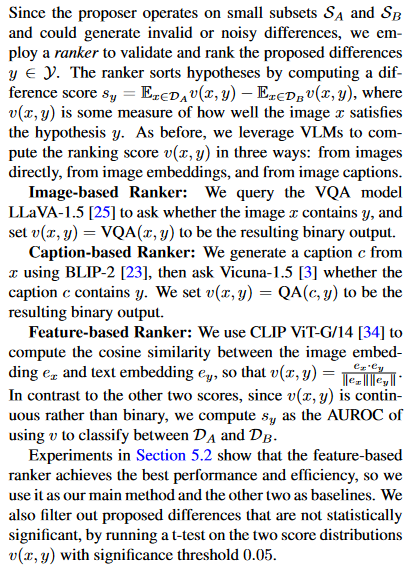

## Ranking differences

At this step, we use CLIP to compute the  cosine similarity between the proposed differences and each image of the two sets.

Then, for each proposed difference, we compute the difference between the mean cosine similarity with the first set of images and the mean cosine similarity with the second set of images.

In order to obtain values ranging from 0 to 1, we compute the AUROC of using the value computed before to classify between the first set and the second set. We use this final score to rank the proposed differences.

### Loading the model

In [ ]:
from transformers import CLIPProcessor, CLIPModel

clip = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

### Utility functions

Processing functions sources from the [official GitHub page](https://github.com/Understanding-Visual-Datasets/VisDiff/blob/a67deb0b917908b3d3eabc2722b38a1b1b11ba6b/components/ranker.py)

In [ ]:
def score_hypothesis(hypothesis, images):
    image_inputs = processor(images=images, return_tensors="pt", padding=True)
    image_features = clip.get_image_features(**image_inputs)

    text_inputs = processor(text=hypothesis, return_tensors="pt", padding=True)
    text_features = clip.get_text_features(**text_inputs)

    similarity = image_features @ text_features.T
    scores = similarity.squeeze(1).tolist()
    return scores

In [ ]:
import seaborn as sns

def plot_distributions(similarity_A_C, similarity_B_C, hypothesis=""):
    """
    Plots the distributions of cos sim to hypothesis for each group.
    """
    # Convert arrays to 1D if they're 2D
    similarity_A_C = np.array(similarity_A_C).ravel()
    similarity_B_C = np.array(similarity_B_C).ravel()

    # Create a combined list of all scores and a list of labels to indicate group membership
    all_scores = list(similarity_A_C) + list(similarity_B_C)
    labels = ["Group A"] * len(similarity_A_C) + ["Group B"] * len(similarity_B_C)

    # Create a DataFrame for seaborn plotting
    df = pd.DataFrame({"Group": labels, "Similarity to C": all_scores})

    # Set up the figure with 3 subplots
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

    # Histogram
    ax[0].hist(similarity_A_C, bins=30, alpha=0.5, label="Group A", density=True)
    ax[0].hist(similarity_B_C, bins=30, alpha=0.5, label="Group B", density=True)
    ax[0].set_title(f"Histogram of Cosine Similarities to \n{hypothesis}")
    ax[0].set_ylabel("Density")
    ax[0].legend()

    # KDE plot
    sns.kdeplot(similarity_A_C, fill=True, ax=ax[1], label="Group A")
    sns.kdeplot(similarity_B_C, fill=True, ax=ax[1], label="Group B")
    ax[1].set_title(
        f"Kernel Density Estimation of Cosine Similarities to \n{hypothesis}"
    )
    ax[1].set_ylabel("Density")

    # Boxplot
    sns.boxplot(x="Group", y="Similarity to C", data=df, ax=ax[2])
    ax[2].set_title(f"Boxplot of Cosine Similarities to \n{hypothesis}")

    # Adjust layout
    plt.tight_layout()
    return fig

In [ ]:
def compute_auroc(similarity_A_C, similarity_B_C):
    similarity_A_C = np.array(similarity_A_C)
    similarity_B_C = np.array(similarity_B_C)

    # Create labels based on the sizes of the input arrays
    labels_A = [1] * similarity_A_C.shape[0]
    labels_B = [0] * similarity_B_C.shape[0]

    # Concatenate scores and labels using numpy's concatenate
    all_scores = np.concatenate([similarity_A_C, similarity_B_C], axis=0).ravel()
    all_labels = labels_A + labels_B

    # Compute AUROC
    auroc = roc_auc_score(all_labels, all_scores)
    return auroc

In [ ]:
def classify(similarity_A_C, similarity_B_C, threshold=0.3):
    """
    Given two arrays of cos sim scores, classify each item of each group as containing concept C or not.
    Return P(hyp in A) - P(hyp in B)
    """
    similarity_A_C = np.array(similarity_A_C)
    similarity_B_C = np.array(similarity_B_C)
    # print(
    #     f"avg(cos sim A, cos sim B) = {[np.mean(similarity_A_C), np.mean(similarity_B_C)]} \t Max(cos sim A, cos sim B) = {[np.max(similarity_A_C), np.max(similarity_B_C)]}"
    # )
    percent_correct_a = sum(similarity_A_C > threshold) / len(similarity_A_C)
    percent_correct_b = sum(similarity_B_C > threshold) / len(similarity_B_C)
    # print(f"Percent correct A, B {[percent_correct_a, percent_correct_b]}")
    return percent_correct_a - percent_correct_b

In [ ]:
from scipy.stats import ttest_ind

def t_test(d_A, d_B):
    d_A = np.array(d_A)
    d_B = np.array(d_B)

    # Assuming you've already defined your similarity scores d_A and d_B
    t_stat, p_value = ttest_ind(d_A, d_B, equal_var=False)

    # Decision
    alpha = 0.05
    if p_value < alpha:
        # print("** Reject the null hypothesis - there's a significant difference between the groups. **")
        return True, p_value
    else:
        # print("Fail to reject the null hypothesis - there's no significant difference between the groups.")
        return False, p_value

In [ ]:
from sklearn.metrics import roc_auc_score
import wandb
def compute_metrics(scores1, scores2, hypothesis):
    metrics = {}
    metrics["hypothesis"] = hypothesis
    metrics["score1"] = np.mean(scores1)
    metrics["score2"] = np.mean(scores2)
    metrics["diff"] = metrics["score1"] - metrics["score2"]
    metrics["t_stat"], metrics["p_value"] = t_test(scores1, scores2)
    metrics["auroc"] = compute_auroc(scores1, scores2)
    metrics["correct_delta"] = classify(scores1, scores2, threshold=0.3)
    metrics["distribution"] = wandb.Image(plot_distributions(scores1, scores2, hypothesis=hypothesis))
    return metrics

Then a ranking based on the `auroc` score is done (same choice of the official GitHub implmentation)

100%|██████████| 10/10 [00:42<00:00,  4.22s/it]


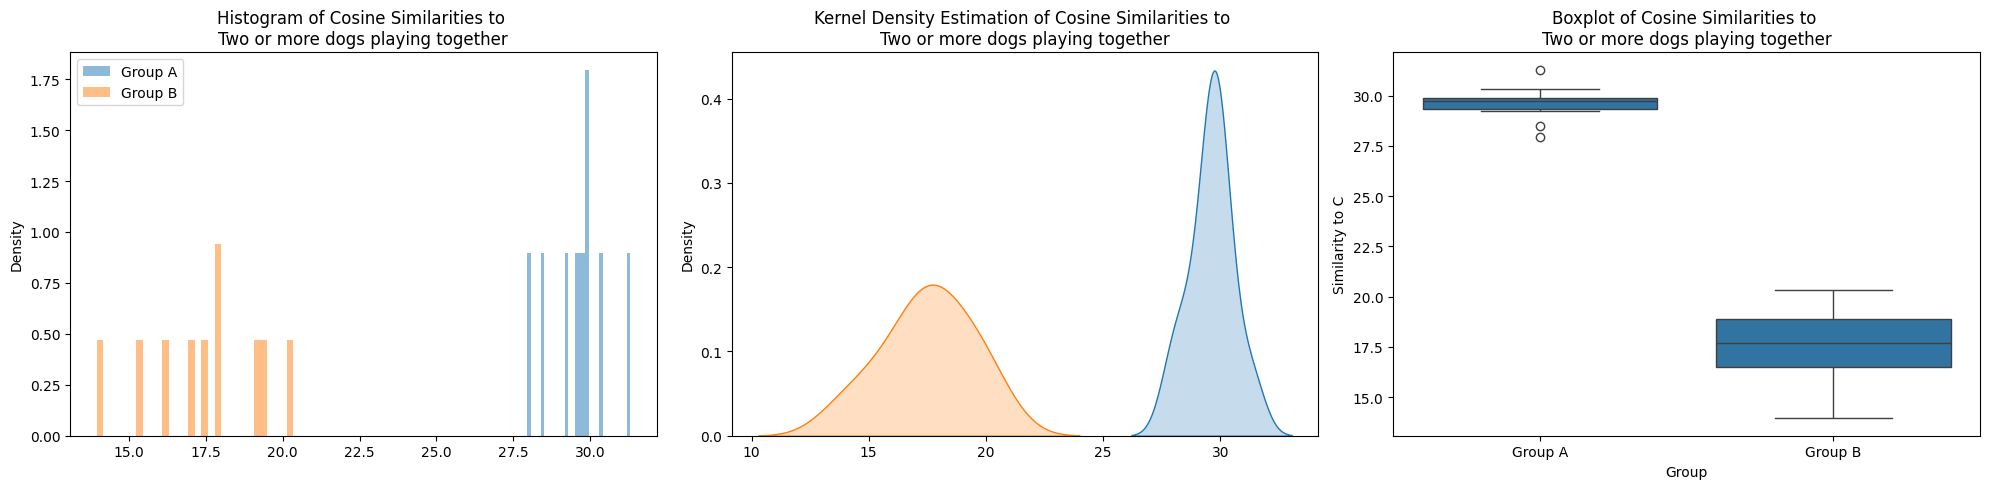

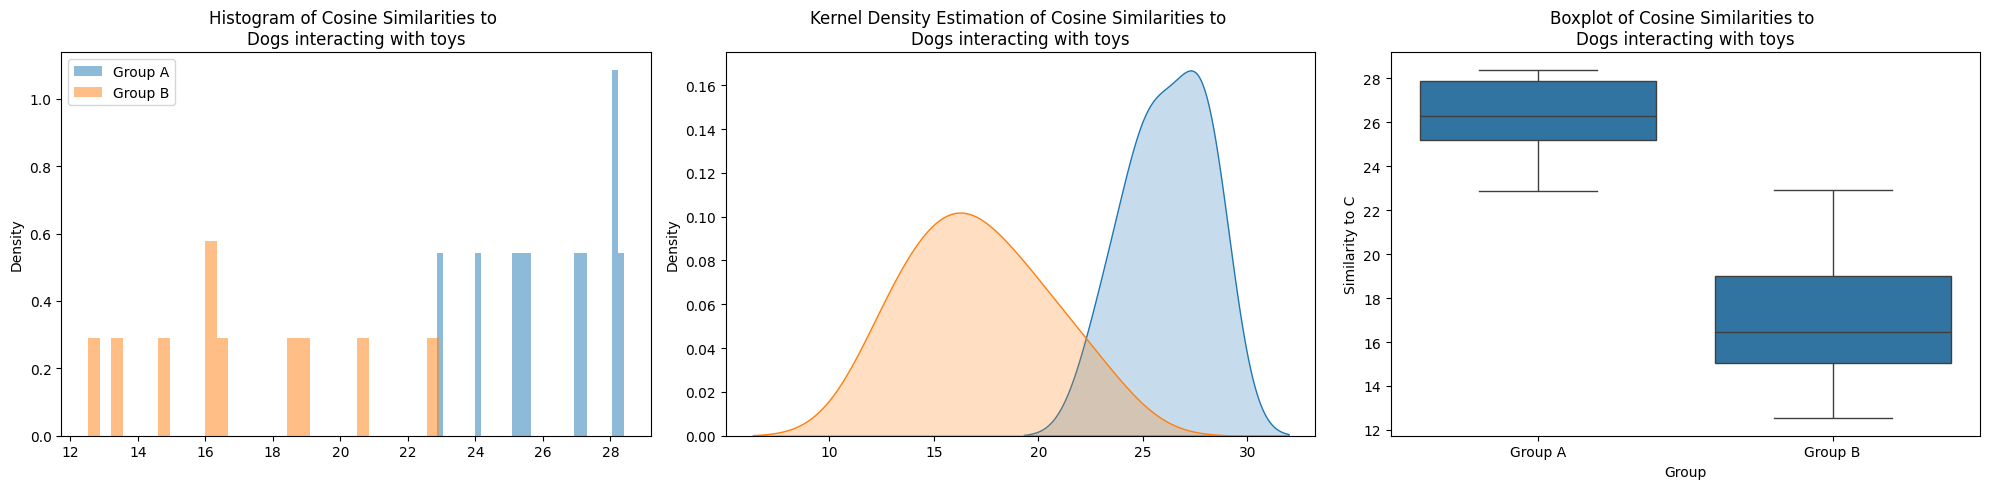

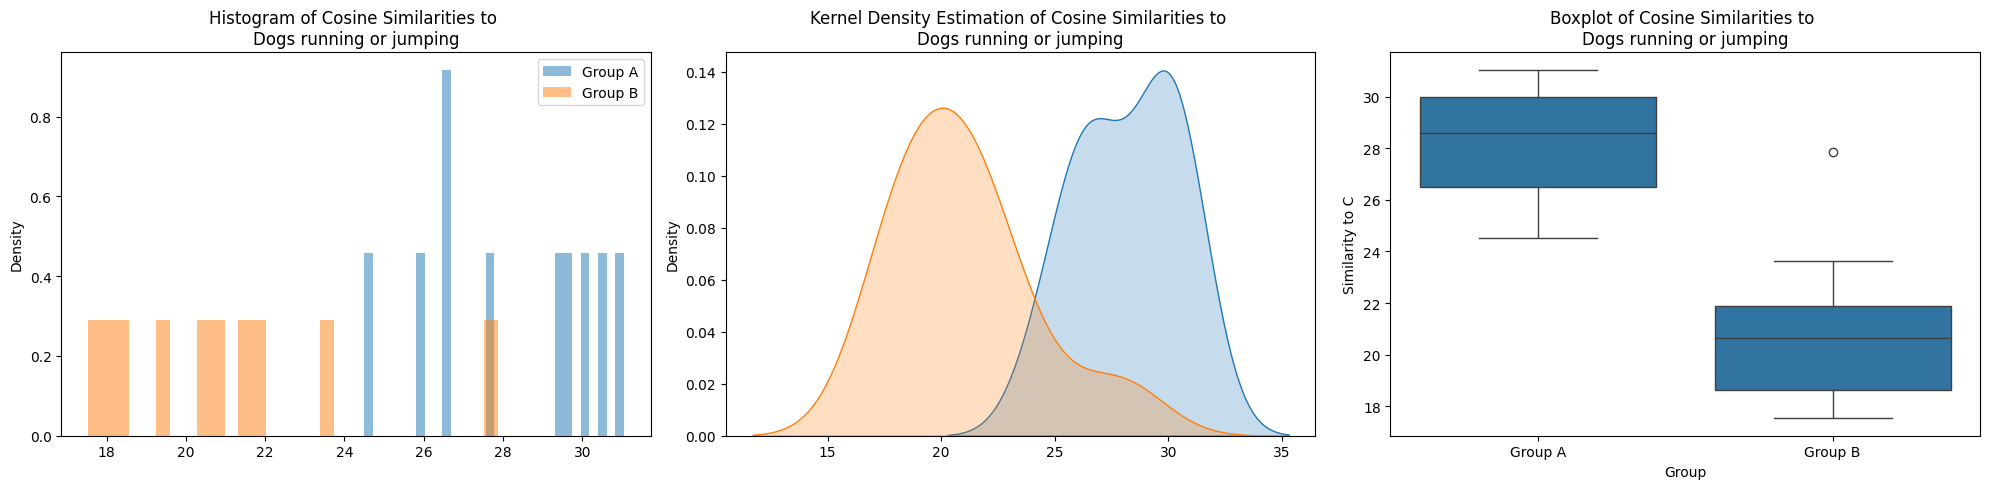

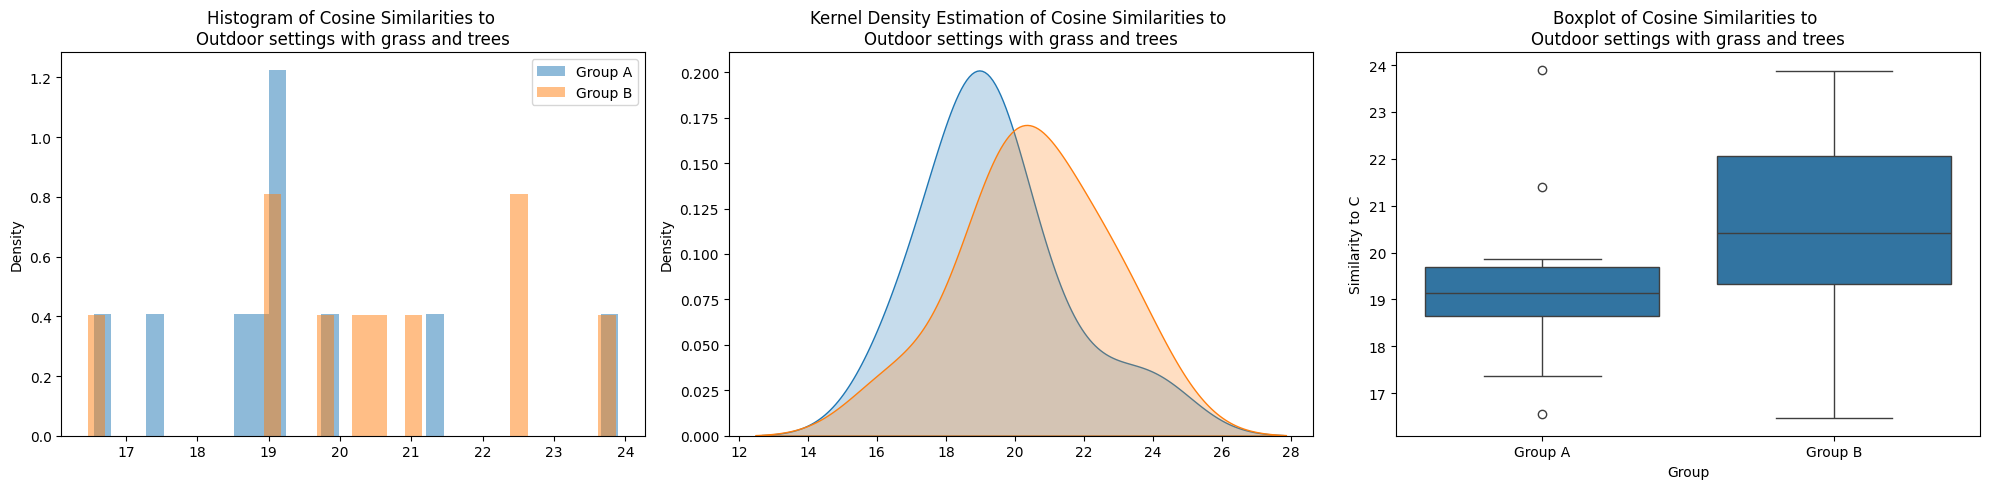

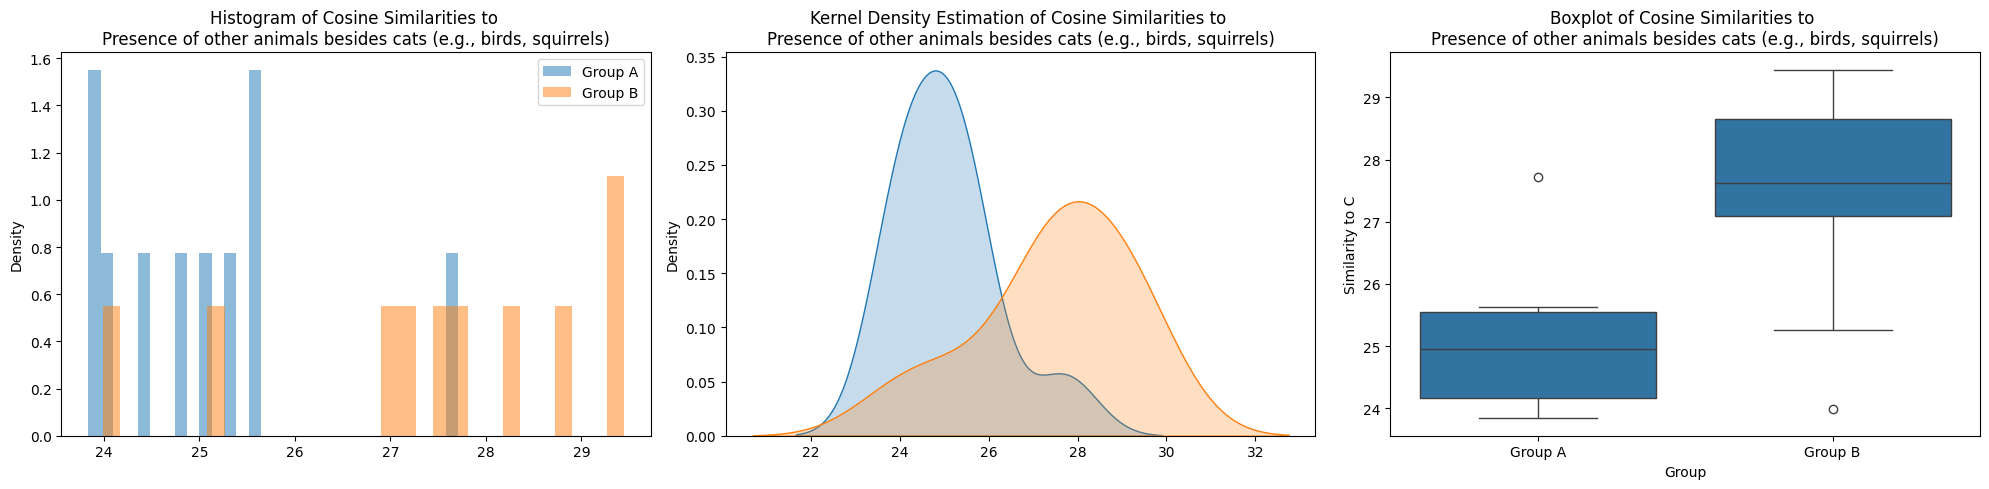

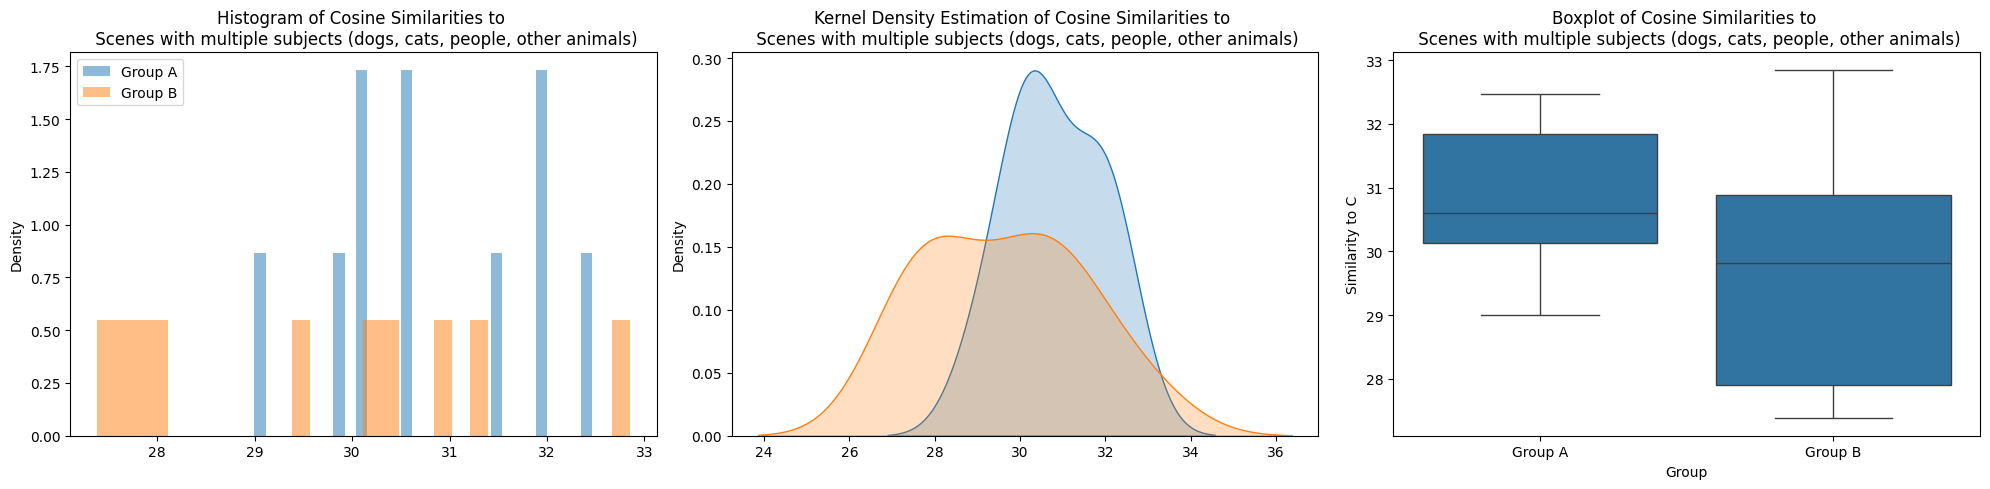

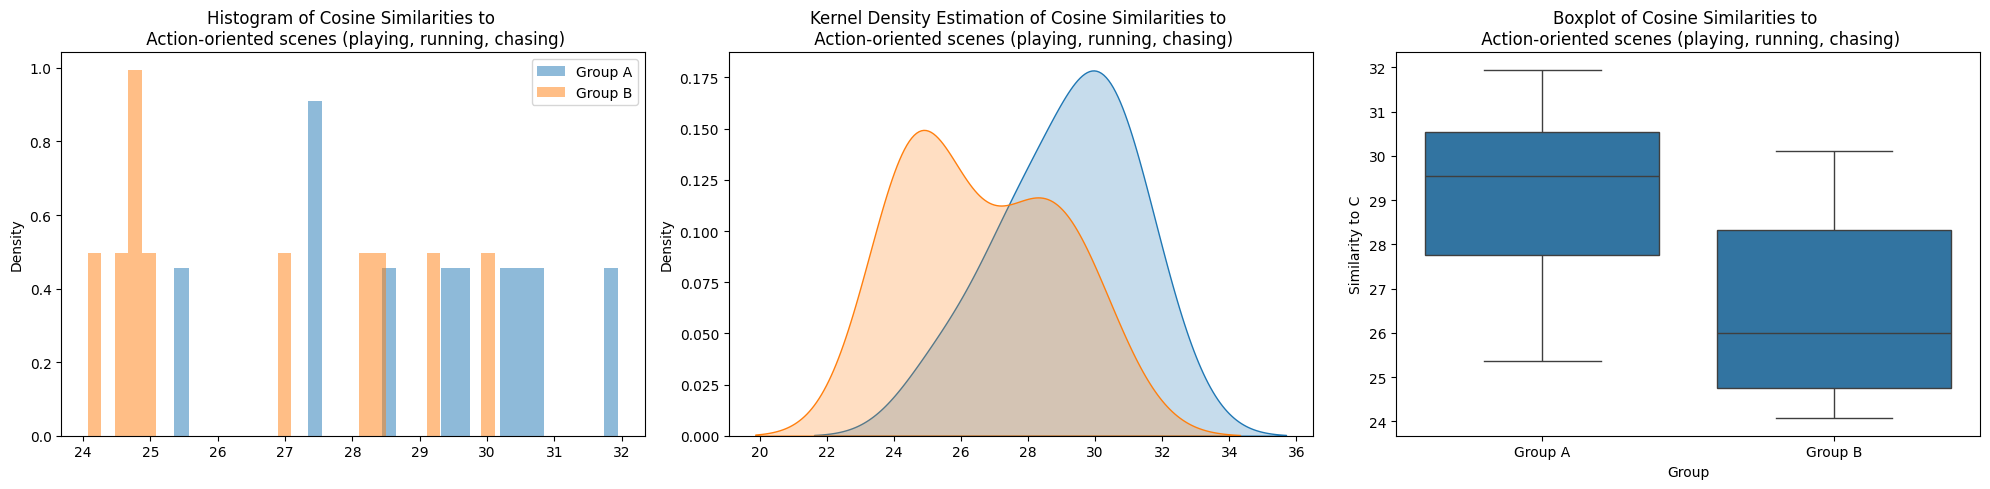

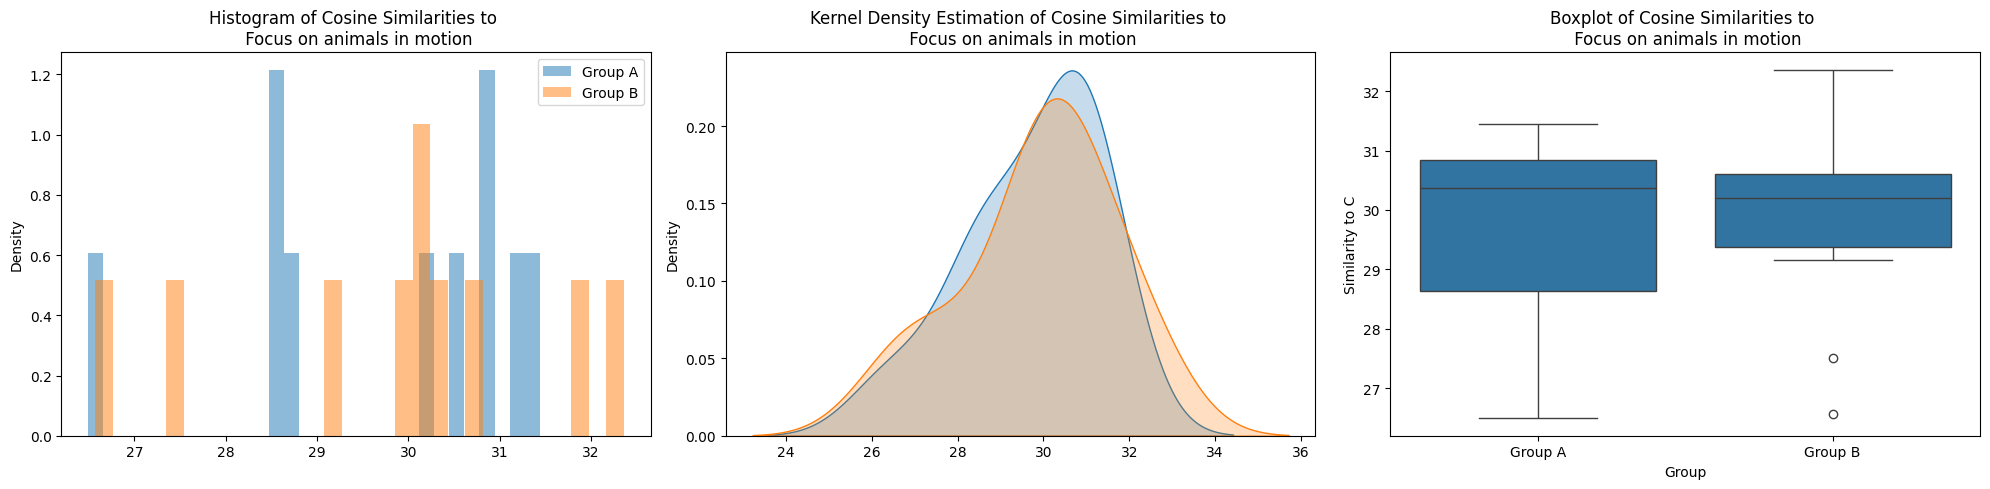

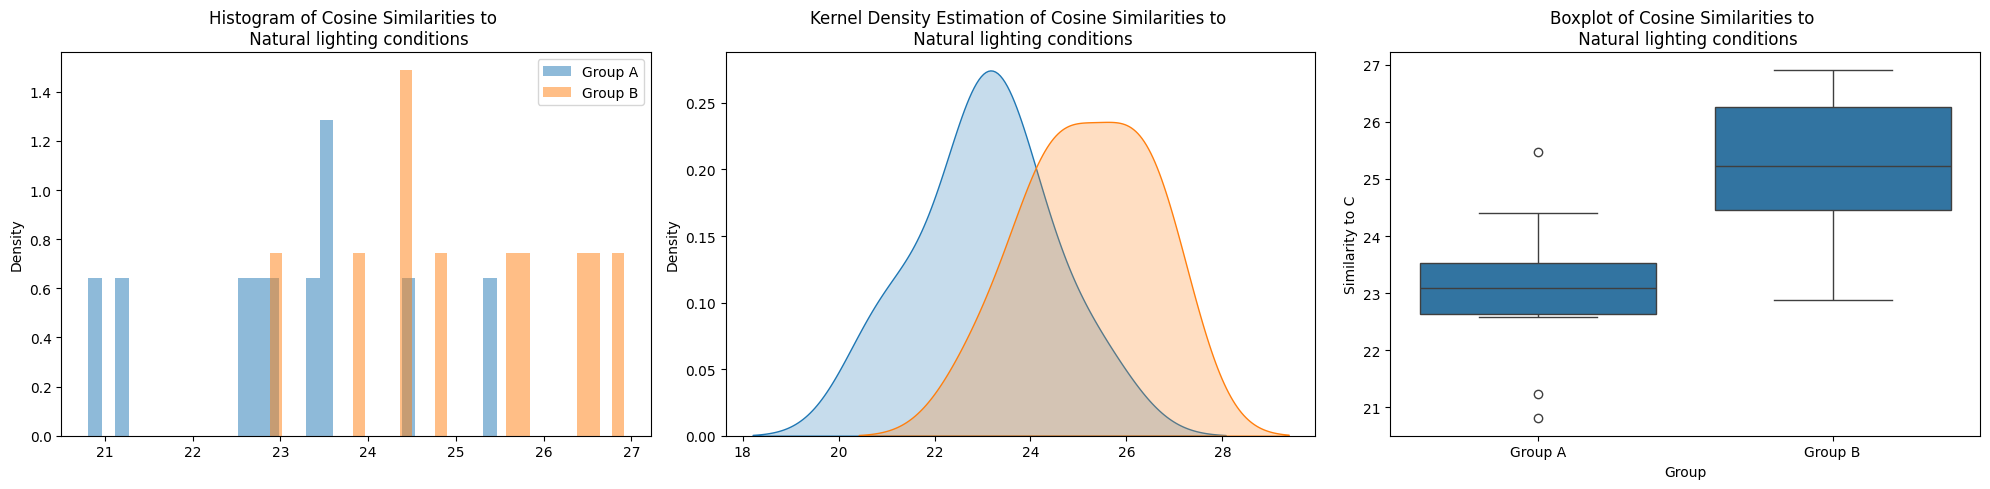

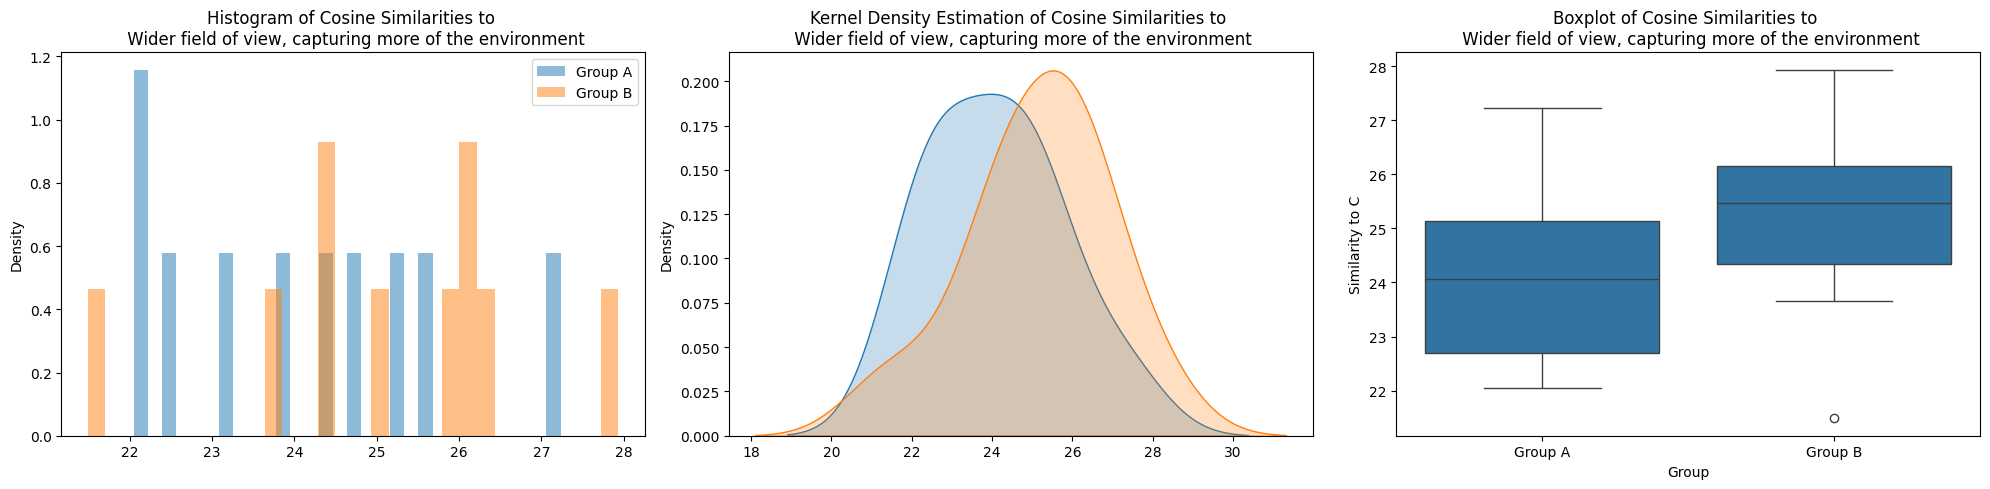

In [ ]:
scored_hypotheses = []

for hypothesis in tqdm(proposed_diffs):
    scores1 = score_hypothesis(hypothesis, all_set1_images)
    scores2 = score_hypothesis(hypothesis, all_set2_images)
    metrics = compute_metrics(scores1, scores2, hypothesis)
    scored_hypotheses.append(metrics)
scored_hypotheses = sorted(scored_hypotheses, key=lambda x: x["auroc"], reverse=True)

## Evaluation

To evaluate the pipeline, we prompt the LLM to compare how similar is the proposed difference with the ground truth. The similarity is scored with integer values from 0 to 2, with 0 being an unrelated proposal and 2 being the best match.

In [ ]:
import re
debug_printing = False # @param {type:"boolean"}

def get_evaluation_score(prompt_text):
    chat = [{"role": "user", "content": prompt_text}]
    prompt = tokenizer.apply_chat_template(chat, tokenize=False, add_generation_prompt=True)
    inputs = tokenizer.encode(prompt, add_special_tokens=False, return_tensors="pt")
    outputs = model.generate(input_ids=inputs.to(model.device), max_new_tokens=200)
    response = tokenizer.decode(outputs[0]).split("<start_of_turn>model")[1].split("<end_of_turn>")[0].strip()

    match = re.match(r'^\d+', response)

    if(debug_printing):
        print("Response from LLM:")
        print(response)
        print("Extracted score: ", int(match.group(0)))

    if match:
        return int(match.group(0))
    else:
        print("No match found.")
        return 0
    # Response will be 0, 1, or 2 (disagree, partially agree, agree)


We then compute the top-1 and top-5 accuracy.

In [ ]:
top_5_hypotheses = [h["hypothesis"] for h in scored_hypotheses[:5]]
correct_top_1 = False
correct_top_5 = False

for i, hypothesis in enumerate(top_5_hypotheses):  # Only the first 5 hypothesis
    prompt_text = EVALUATION_WITH_GROUND_TRUTH_PROMPT.format(
        gt_a=data["set1"],
        gt_b=data["set2"],
        hypothesis=hypothesis
    )
    evaluation_score = get_evaluation_score(prompt_text)  # Get the model score

    if i == 0 and evaluation_score == 2:  # Check Top-1
        correct_top_1 = True
    if evaluation_score == 2:  # Check Top-5
        correct_top_5 = True
        break  # One correct Hypothesis is enought for the Top-5

## Results

Here are the results, useful when comparing all of the five image pairs together:

In [ ]:
print(f"Correct response is in the first position: {correct_top_1}")
print(f"Correct response is in the first five positions: {correct_top_5}")

Correct response is in the first position: True
Correct response is in the first five positions: True
